In [60]:
from copy import copy
import math
import os
from pathlib import Path
import pickle
from adjustText import adjust_text
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
SMALL_FONT = 10
MEDIUM_FONT = 12
LARGE_FONT = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rc('font',size=SMALL_FONT) # controls default text sizes
plt.rc('axes',titlesize=MEDIUM_FONT) # fontsize of the axes title
plt.rc('axes',labelsize=SMALL_FONT) # fontsize of the x and y labels
plt.rc('xtick',labelsize=SMALL_FONT) # fontsize of the tick labels
plt.rc('ytick',labelsize=SMALL_FONT) # fontsize of the tick labels
plt.rc('legend',fontsize=SMALL_FONT) # legend fontsize
plt.rc('figure',titlesize=LARGE_FONT) # fontsize of the figure title

In [3]:
def get_summary(experiment):
    grid = pd.read_csv(os.path.join(KWARGS['misc_directory'],f'{experiment}_grid.csv'))
    summary = pd.read_csv(os.path.join(KWARGS['summary_directory'],f'{experiment}.csv'))
    summary = grid.merge(summary,on='simulation_id',how='inner')

    # score summary
    columns = [
        'net_electricity_consumption_sum',
        'net_electricity_consumption_emission_sum',
        'net_electricity_consumption_price_sum',
        'net_electricity_consumption_without_storage_sum',
        'net_electricity_consumption_emission_without_storage_sum',
        'net_electricity_consumption_price_without_storage_sum',
        'reward_sum',
    ]
    score_summary = summary.groupby(['group','simulation_id','episode'])[columns].sum().reset_index()
    score_summary['consumption_score'] = score_summary['net_electricity_consumption_sum']\
        /score_summary['net_electricity_consumption_without_storage_sum']
    score_summary['price_score'] = score_summary['net_electricity_consumption_price_sum']\
        /score_summary['net_electricity_consumption_price_without_storage_sum']
    score_summary['emission_score'] = score_summary['net_electricity_consumption_emission_sum']\
        /score_summary['net_electricity_consumption_emission_without_storage_sum']
    score_columns = ['consumption_score','price_score','emission_score']
    score_summary = score_summary.groupby(['group','episode'])[score_columns + ['reward_sum']].mean().reset_index()
    score_summary['average_score'] = score_summary[score_columns].mean(axis=1)
    score_summary['average_price_and_emission_score'] = score_summary[['price_score','emission_score']].mean(axis=1)

    return grid, summary, score_summary

def plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None):
    row_count = 1
    column_count = 3
    ylim = (
        plot_data[['average_price_and_emission_score','price_score','emission_score']].min().min(),
        plot_data[['average_price_and_emission_score','price_score','emission_score']].max().max()
    )

    for fig_names, type_group in plot_data.groupby(fig_groupby_columns):
        fig, axs = plt.subplots(row_count,column_count,figsize=(4*column_count,2.0*row_count),sharey=True)
        
        for ax_names, simulation_id_group in type_group.groupby(ax_groupby_columns):
            if round_number:
                label = str(tuple([round(n,round_number) for n in ax_names]))
            else:
                label = str(ax_names)

            simulation_id_group = simulation_id_group.sort_values('episode')

            # cost
            x, y = simulation_id_group['episode'], simulation_id_group['price_score']
            axs[0].plot(x,y,label=label)
            axs[0].set_title('Price')

            # carbon_emission
            x, y = simulation_id_group['episode'], simulation_id_group['emission_score']
            axs[1].plot(x,y,label=label)
            axs[1].set_title('Carbon emission')

            # average
            x, y = simulation_id_group['episode'], simulation_id_group['average_price_and_emission_score']
            axs[2].plot(x,y,label=label)
            axs[2].set_title('Average')

        for i, ax in enumerate(fig.axes):
            ax.set_xlabel('Episode')
            ax.set_ylim(ylim)
            ax.axhline(1.0,color='black',linestyle='--')

            if i == 0:
                ax.legend(
                    bbox_to_anchor=(0.5,-0.1),
                    loc='upper center', 
                    bbox_transform=fig.transFigure,
                    framealpha=0,
                    ncol=7
                )
            else:
                pass
        
        fig.suptitle(f'{fig_names}',y=1.10)
        plt.show()

# Reward Design

In [4]:
reward_design_grid, reward_design_summary, reward_design_score_summary = get_summary('reward_design')
reward_design_grid['e'] = reward_design_grid['exponent']
reward_design_grid['w_1'] = reward_design_grid['weight']
reward_design_grid['w_2'] = 1.0 - reward_design_grid['weight']
metadata = reward_design_grid[['group','type','e','w_1','w_2']].drop_duplicates()
reward_design_score_summary = metadata.merge(reward_design_score_summary,on='group',how='left')

# ordered average score by last episode 
display(reward_design_score_summary[reward_design_score_summary['episode']==9][[
    'group','type','e','w_1','w_2','episode',
    'average_score','average_price_and_emission_score',
    'price_score','emission_score','consumption_score',
]].sort_values('average_price_and_emission_score'))

,group,type,e,w_1,w_2,episode,average_score,average_price_and_emission_score,price_score,emission_score,consumption_score
269,20,reward.AdditiveSolarPenaltyReward,1,1.0,0.0,9,0.959991,0.939641,0.866921,1.012361,1.000693
209,17,reward.AdditiveSolarPenaltyReward,1,0.5,0.5,9,0.985213,0.977109,0.926961,1.027258,1.001421
249,19,reward.AdditiveSolarPenaltyReward,1,0.8,0.2,9,0.985374,0.977459,0.922564,1.032354,1.001203
229,18,reward.AdditiveSolarPenaltyReward,1,0.6,0.4,9,0.994329,0.990923,0.943874,1.037972,1.001141
189,16,reward.AdditiveSolarPenaltyReward,1,0.4,0.6,9,0.994658,0.991391,0.954299,1.028484,1.001192
279,27,reward.AdditiveSolarPenaltyReward,2,1.0,0.0,9,0.995295,0.992905,0.862829,1.122980,1.000077
239,25,reward.AdditiveSolarPenaltyReward,2,0.6,0.4,9,1.001193,1.001450,0.884423,1.118478,1.000679
219,24,reward.AdditiveSolarPenaltyReward,2,0.5,0.5,9,1.003352,1.004512,0.885626,1.123398,1.001032
9,0,reward.AdditiveReward,1,0.0,1.0,9,1.006486,1.009225,0.991528,1.026922,1.001008
169,15,reward.AdditiveSolarPenaltyReward,1,0.2,0.8,9,1.007562,1.010748,0.979395,1.042102,1.001190


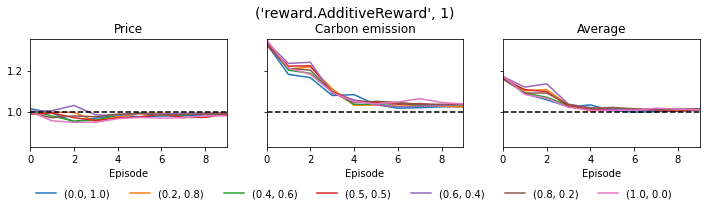

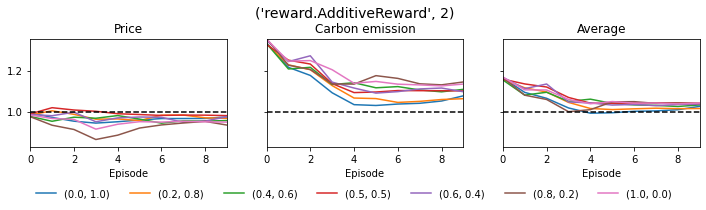

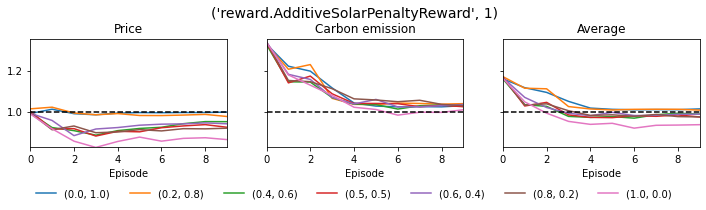

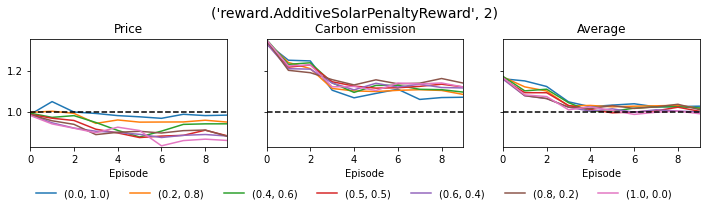

In [5]:
# score trajectory
plot_data = reward_design_score_summary.copy()
fig_groupby_columns = ['type','e']
ax_groupby_columns = ['w_1','w_2']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=1)

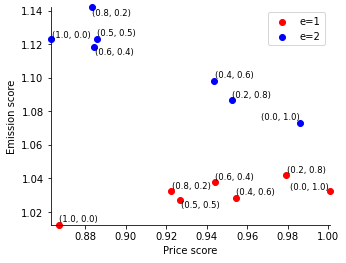

In [10]:
# emission - price scattear
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_data = reward_design_score_summary[
    (reward_design_score_summary['type']=='reward.AdditiveSolarPenaltyReward')
    &(reward_design_score_summary['episode']==9)
].copy()
colors = ['red','blue']
texts = []

for i, (e, plot_data) in enumerate(plot_data.groupby('e')):
    x, y = plot_data['price_score'], plot_data['emission_score']
    lim = (min(x.tolist() + y.tolist()), max(x.tolist() + y.tolist()))
    ax.scatter(x,y,clip_on=False,color=colors[i],label=f'e={e}')

    for x_, y_, w_1, w_2 in plot_data[['price_score','emission_score','w_1','w_2']].to_records(index=False):
        texts.append(ax.text(x_,y_,f'({round(w_1,1)}, {round(w_2,1)})',ha='center',va='center',color='black',fontsize=8.5))


ax.spines[['right','top']].set_visible(False)
adjust_text(texts)
ax.set_xlabel('Price score')
ax.set_ylabel('Emission score')
ax.legend()
filepath = os.path.join(KWARGS['figure_directory'],'reward_design_scatter.pdf')
plt.savefig(filepath,transparent=True,bbox_inches='tight')
plt.show()

# Hyperparameter Design

In [89]:
hyperparameter_design_grid, hyperparameter_design_summary, hyperparameter_design_score_summary = get_summary('hyperparameter_design')
metadata = hyperparameter_design_grid[['group','discount','tau','lr','alpha']].drop_duplicates()
hyperparameter_design_score_summary = metadata.merge(hyperparameter_design_score_summary,on='group',how='left')

# ordered average score by last episode 
display(hyperparameter_design_score_summary[hyperparameter_design_score_summary['episode']==9][[
    'group','discount','tau','lr','alpha','episode','reward_sum',
    'average_score','average_price_and_emission_score',
    'price_score','emission_score','consumption_score',
]].sort_values('average_price_and_emission_score').head(10))

,group,discount,tau,lr,alpha,episode,reward_sum,average_score,average_price_and_emission_score,price_score,emission_score,consumption_score
279,74,0.99,0.0500,0.00005,0.8,9,-808.870958,0.974290,0.960571,0.873686,1.047457,1.001728
349,67,0.99,0.0050,0.00050,0.5,9,-805.463909,0.977921,0.966342,0.902535,1.030149,1.001080
459,14,0.90,0.0050,0.00050,0.8,9,-809.074991,0.984629,0.976611,0.915077,1.038146,1.000664
439,16,0.90,0.0050,0.00500,0.5,9,-806.854413,0.987962,0.981407,0.924712,1.038101,1.001072
139,46,0.95,0.0500,0.00005,0.5,9,-822.924859,0.988193,0.981951,0.905818,1.058085,1.000675
429,17,0.90,0.0050,0.00500,0.8,9,-801.129725,0.989527,0.983672,0.936526,1.030818,1.001235
749,26,0.90,0.0500,0.00500,0.8,9,-809.540796,0.989953,0.984359,0.928248,1.040471,1.001141
669,35,0.95,0.0005,0.00500,0.8,9,-805.500904,0.990640,0.985229,0.936383,1.034076,1.001462
529,7,0.90,0.0005,0.00500,0.5,9,-812.673276,0.991017,0.985966,0.928495,1.043437,1.001119
199,62,0.99,0.0005,0.00500,0.8,9,-789.776982,0.991417,0.986442,0.962608,1.010276,1.001365


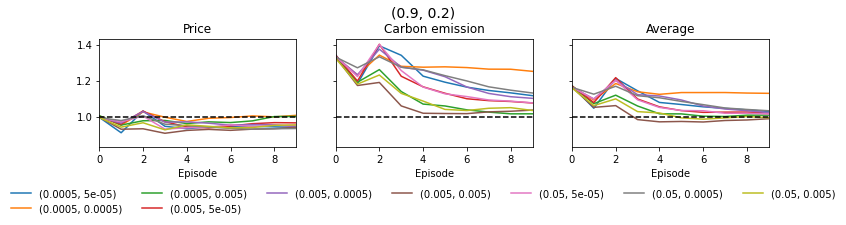

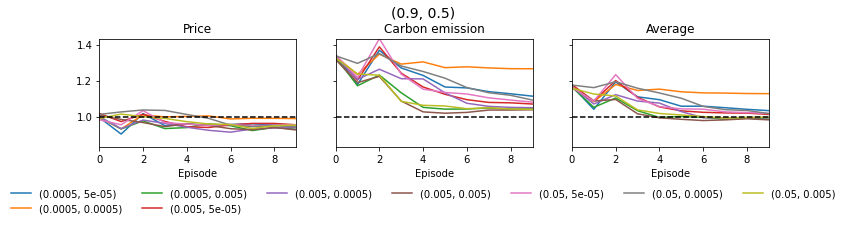

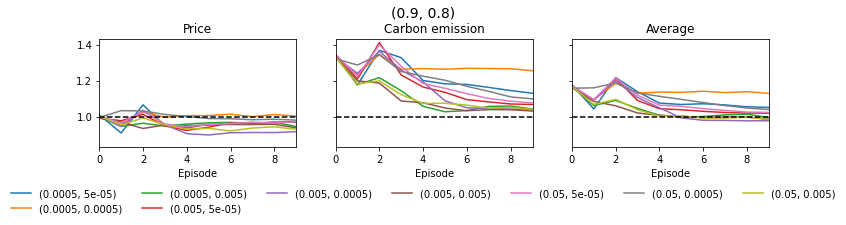

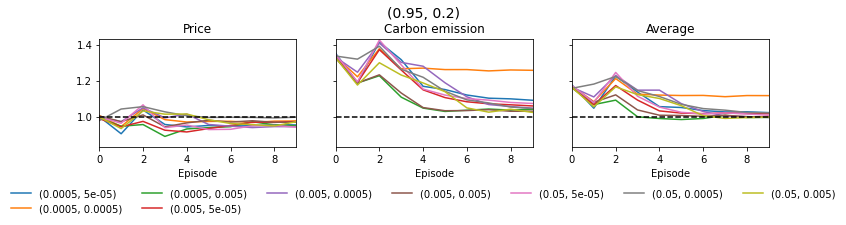

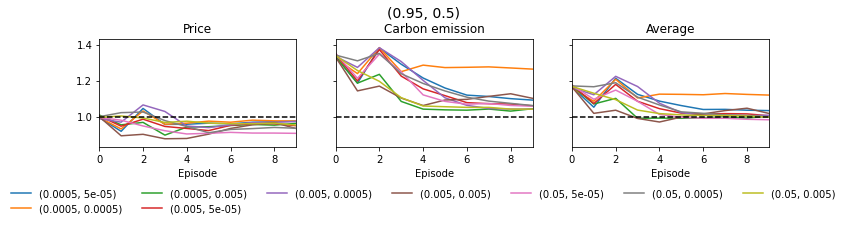

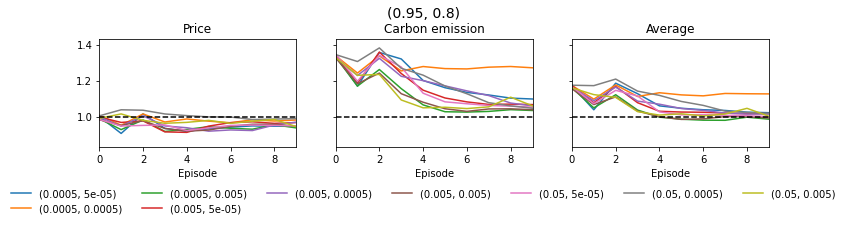

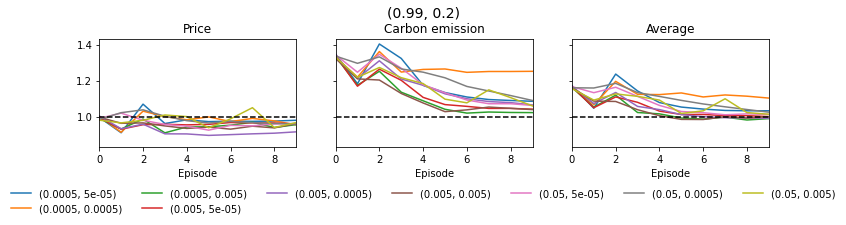

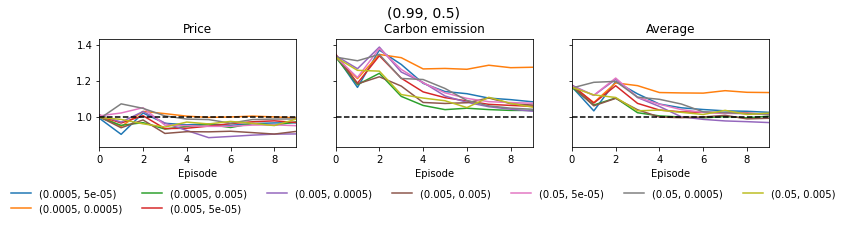

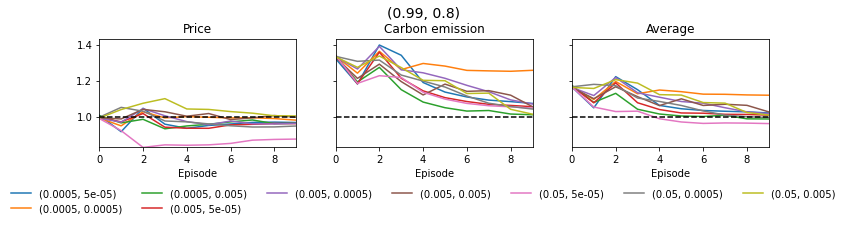

In [90]:
# score trajectory
plot_data = hyperparameter_design_score_summary.copy()
fig_groupby_columns = ['discount','alpha']
ax_groupby_columns = ['tau','lr']
plot_score_trajectory(plot_data,fig_groupby_columns,ax_groupby_columns,round_number=None)

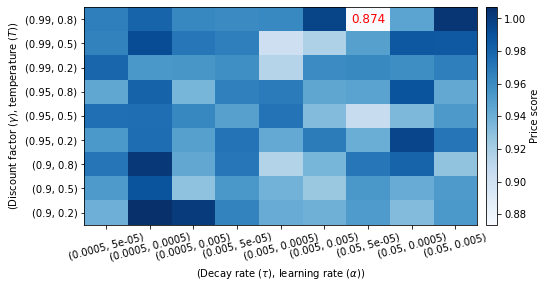

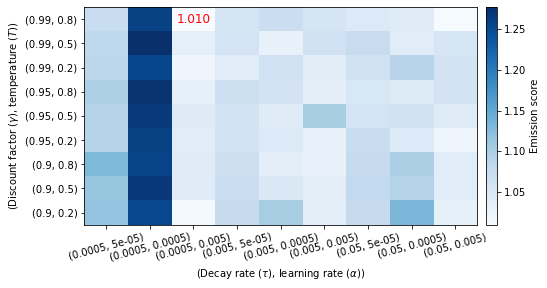

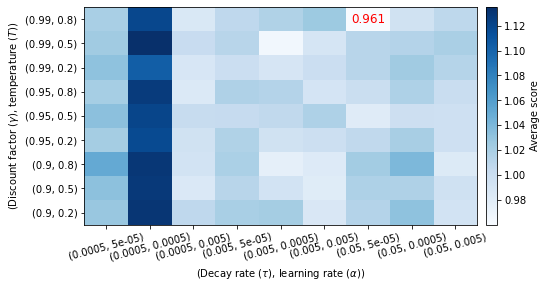

In [91]:
# final episode heat map
cmap = 'Blues'
cmap = copy(cm.get_cmap(cmap))
cmap.set_bad(color='grey')
shading = 'nearest'
cb_fraction = 0.1
cb_pad = 0.02
labels = ['Price', 'Emission', 'Average']
columns = ['price_score','emission_score','average_price_and_emission_score']

for c, l in zip(columns,labels):
    plot_data = hyperparameter_design_score_summary[
        hyperparameter_design_score_summary['episode']==9
    ].pivot_table(index=['discount','alpha'],columns=['tau','lr'],values=c)
    x, y, z = plot_data.columns.tolist(), plot_data.index, plot_data.values
    x_labels = [str(x_) for x_ in x]
    y_labels = [str(y_) for y_ in y]
    x = list(range(len(x)))
    y = list(range(len(y)))
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    pcm = ax.pcolormesh(x,y,z,shading=shading,cmap=cmap)
    ax.set_xlabel(r'(Decay rate ($\tau$), learning rate ($\alpha$))')
    ax.set_ylabel(r'(Discount factor ($\gamma$), temperature ($T$))')
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    for (i, j), v in np.ndenumerate(plot_data):
        if v == z.min():
            ax.text(j,i,f'{v:0.3f}',ha='center',va='center',color='red',fontsize=12)
        else:
            continue

    ax.tick_params('x',which='both',rotation=15)
    _ = fig.colorbar(pcm,ax=ax,fraction=0.1,pad=cb_pad,label=f'{l} score')
    filepath = os.path.join(KWARGS['figure_directory'],f'hyperparameter_design_{l.lower()}_heat_map.pdf')
    plt.savefig(filepath,transparent=True,bbox_inches='tight')
    plt.show()

# RBC Validation

In [109]:
# RBC Validation
# read actual battery consumption
battery_data = pd.read_csv(os.path.join(misc_directory,'battery_electricity_consumption.csv'))
battery_data.columns = ['timestamp','building_id','actual_electrical_storage_electricity_consumption']
buildings = [2,3,6,7,8,9]
battery_data = battery_data[battery_data['building_id'].isin(buildings)]
battery_data['timestamp'] = pd.to_datetime(battery_data['timestamp'])
battery_data['building_id'] = battery_data['building_id'].map(lambda x: f'Building_{x}')
timestamps =pd.DataFrame({'timestamp':battery_data['timestamp'].unique()})

# read simulation data
rbc_validation_grid_filepath = os.path.join(misc_directory,'rbc_validation_grid.csv')
rbc_validation_grid = pd.read_csv(rbc_validation_grid_filepath)
rbc_validation_simulations = []

for simulation_id in rbc_validation_grid['simulation_id'].tolist():
    filepath = os.path.join(result_directory,f'{simulation_id}_episode_0.pkl')
    
    with (open(filepath, 'rb')) as openfile:
        env = pickle.load(openfile)

    for b in env.buildings:
        data = pd.DataFrame({
            'simulation_net_electricity_consumption':b.net_electricity_consumption,
            'simulation_net_electricity_consumption_without_storage':b.net_electricity_consumption_without_storage,
            'simulation_electrical_storage_net_electricity_consumption':b.electrical_storage.electricity_consumption,
        })
        data['building_id'] = b.name
        data['timestamp'] = timestamps
        data['simulation_id'] = simulation_id
        rbc_validation_simulations.append(data)

rbc_validation_simulations = pd.concat(rbc_validation_simulations,ignore_index=True)
rbc_validation_simulations = rbc_validation_simulations.merge(rbc_validation_grid,on='simulation_id',how='inner')
rbc_validation_simulations = rbc_validation_simulations.merge(battery_data,on=['building_id','timestamp'],how='inner')
rbc_validation_simulations['error'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption'] - rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['ratio'] =  rbc_validation_simulations['simulation_electrical_storage_net_electricity_consumption']/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['percentage_error'] = rbc_validation_simulations['error']*100/rbc_validation_simulations['actual_electrical_storage_electricity_consumption']
rbc_validation_simulations['hour'] = rbc_validation_simulations['timestamp'].dt.hour

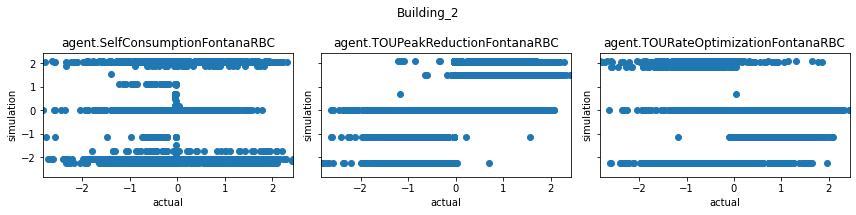

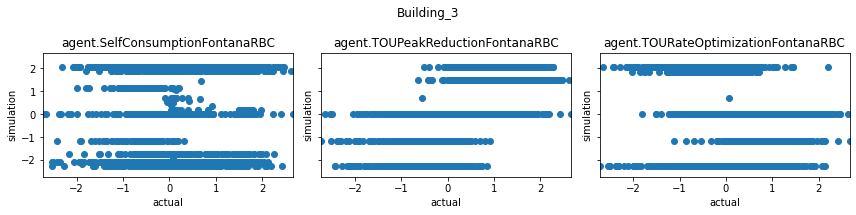

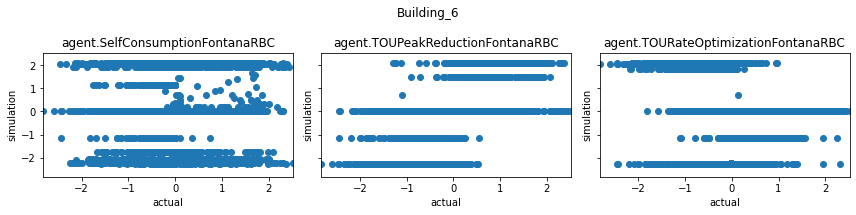

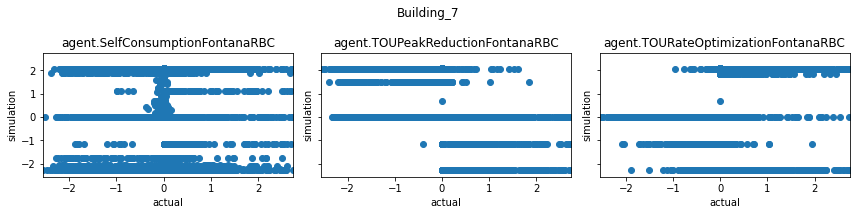

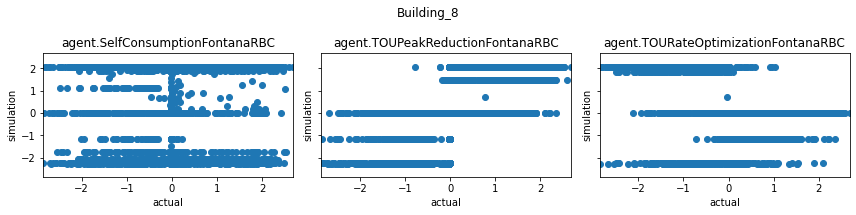

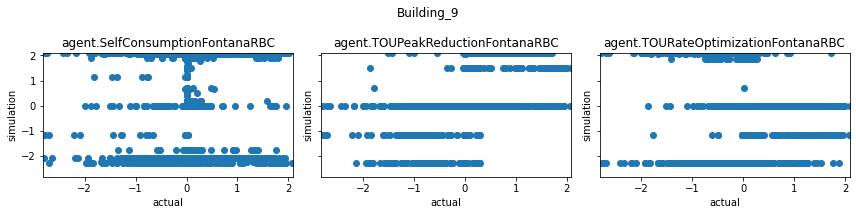

In [106]:
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,3*row_count),sharex=True,sharey=True)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['actual_electrical_storage_electricity_consumption'] 
        y = rbc_data['simulation_electrical_storage_net_electricity_consumption']
        lim = (min(x.min(),y.min()), max(x.max(),y.max()))
        ax.scatter(x,y)
        ax.set_xlabel('actual')
        ax.set_ylabel('simulation')
        ax.set_title(rbc_type)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

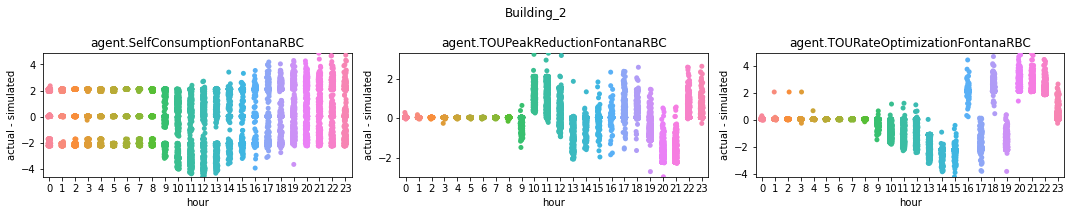

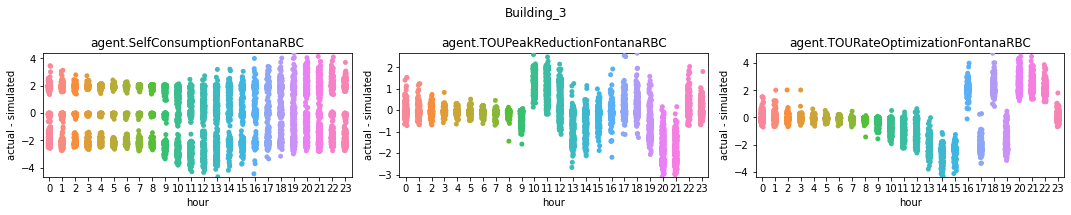

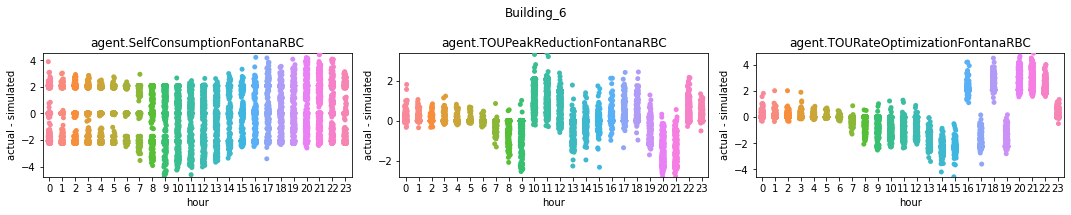

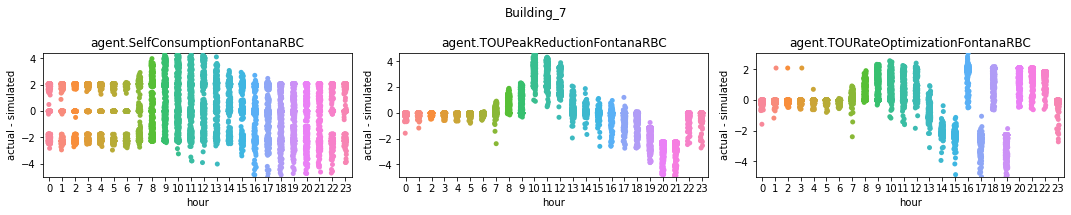

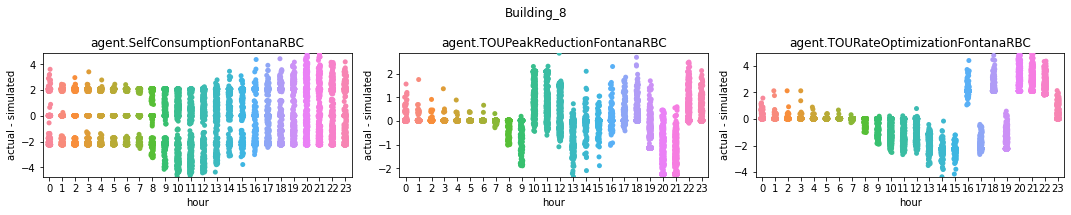

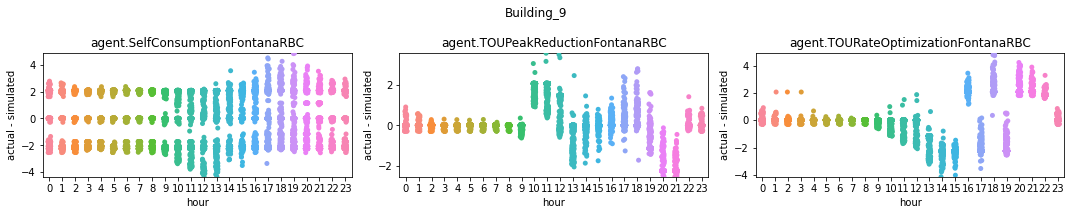

In [114]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        sns.stripplot(x='hour',y='error',data=rbc_data,ax=ax)
        ax.set_xlabel('hour')
        ax.set_ylabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

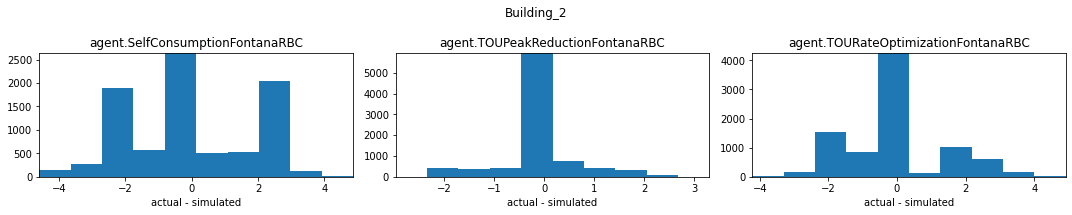

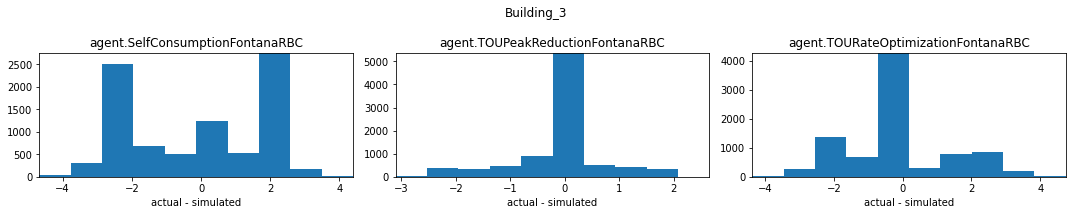

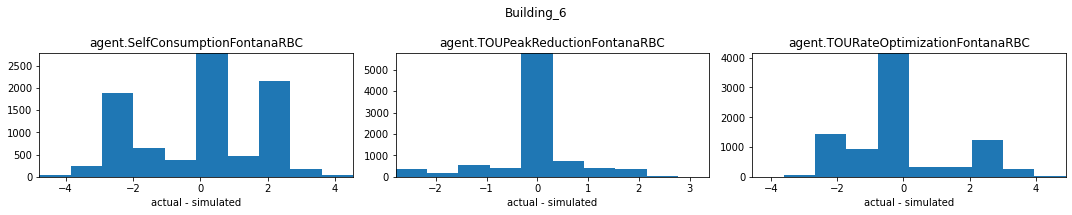

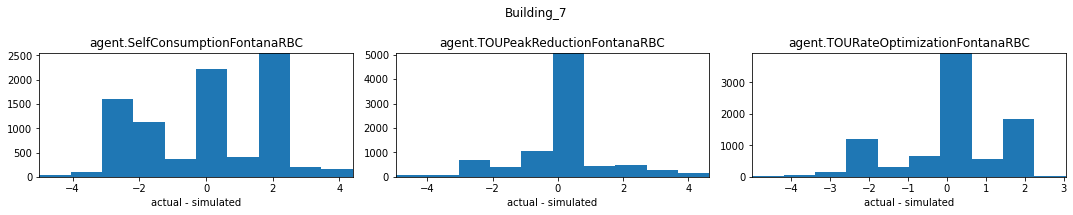

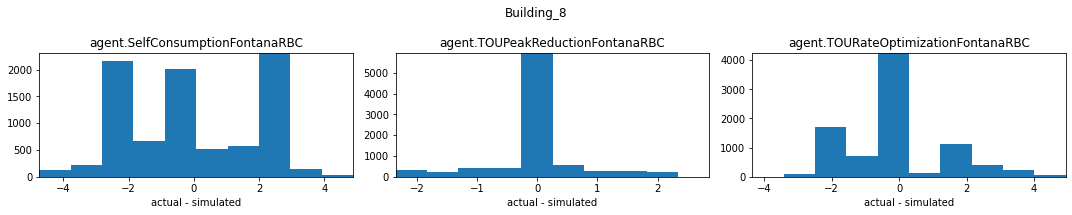

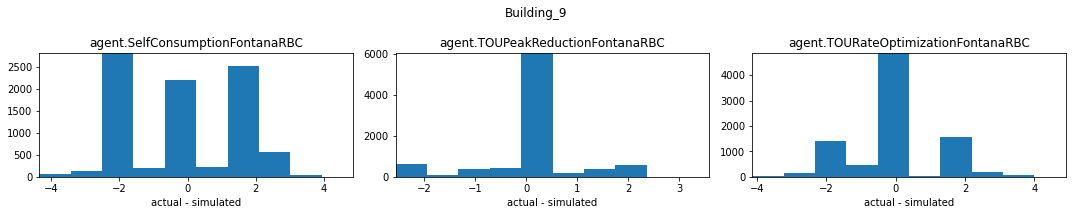

In [144]:
# hourly difference between actual and simulated
for building, building_data in rbc_validation_simulations.groupby('building_id'):
    row_count = 1
    column_count = len(rbc_validation_grid)
    fig, axs = plt.subplots(row_count, column_count, figsize=(5*column_count,3*row_count),sharey=False)

    for ax, (rbc_type, rbc_data) in zip(fig.axes, building_data.groupby('type')):
        x = rbc_data['error']
        ax.hist(x)
        ax.set_xlabel('actual - simulated')
        ax.set_title(rbc_type)
    
    fig.suptitle(building)
    plt.tight_layout()
    plt.show()

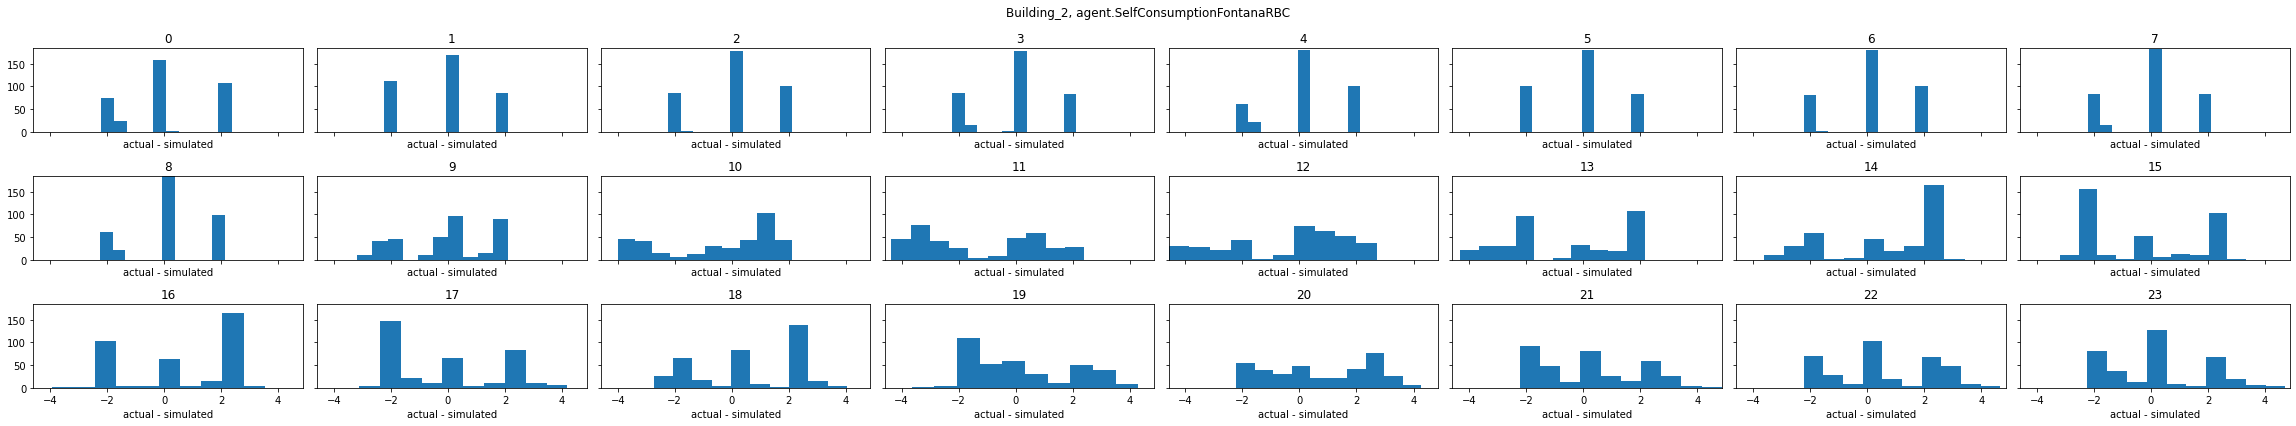

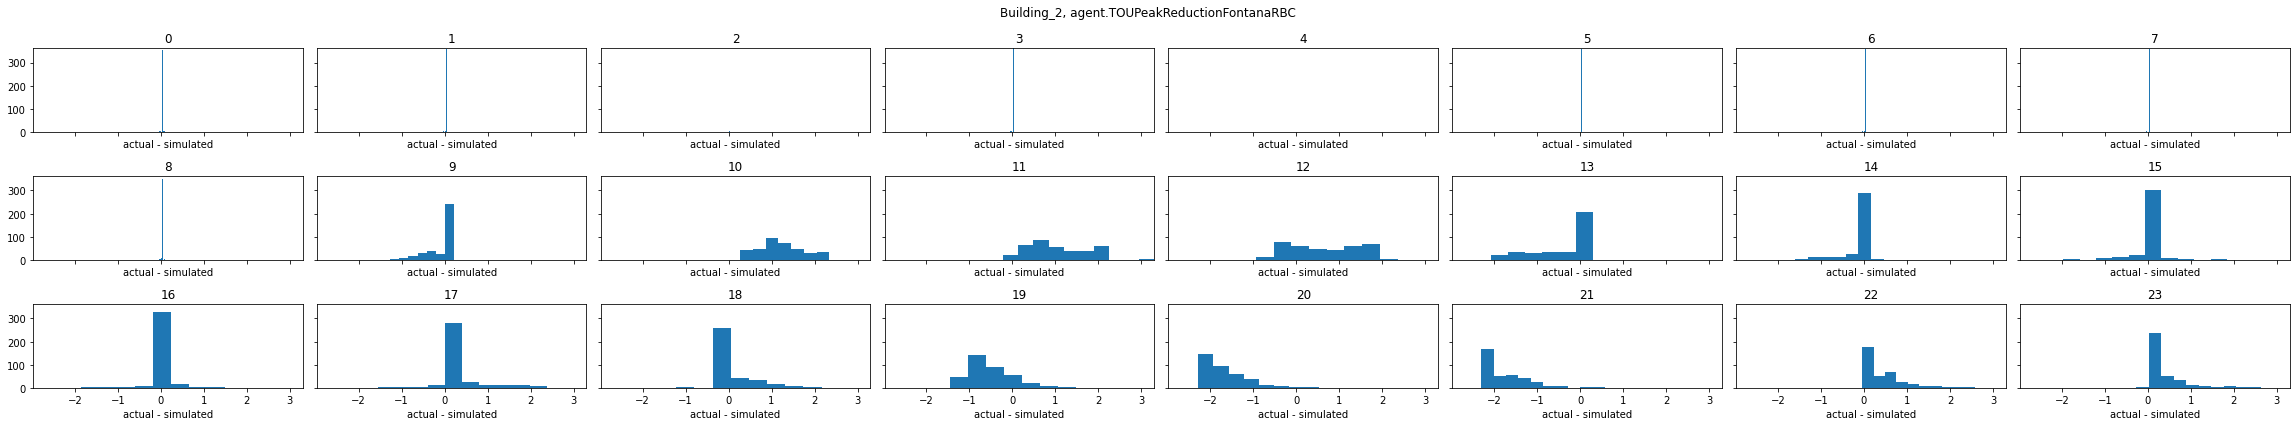

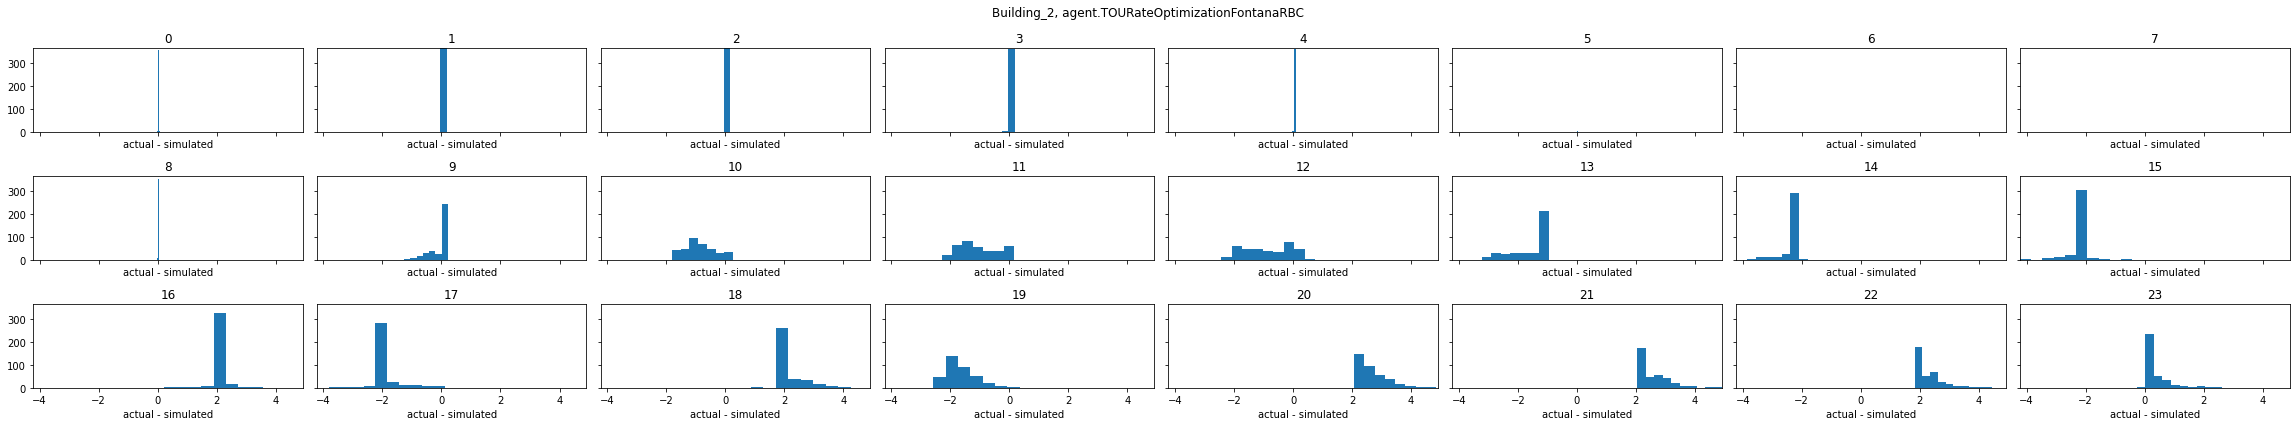

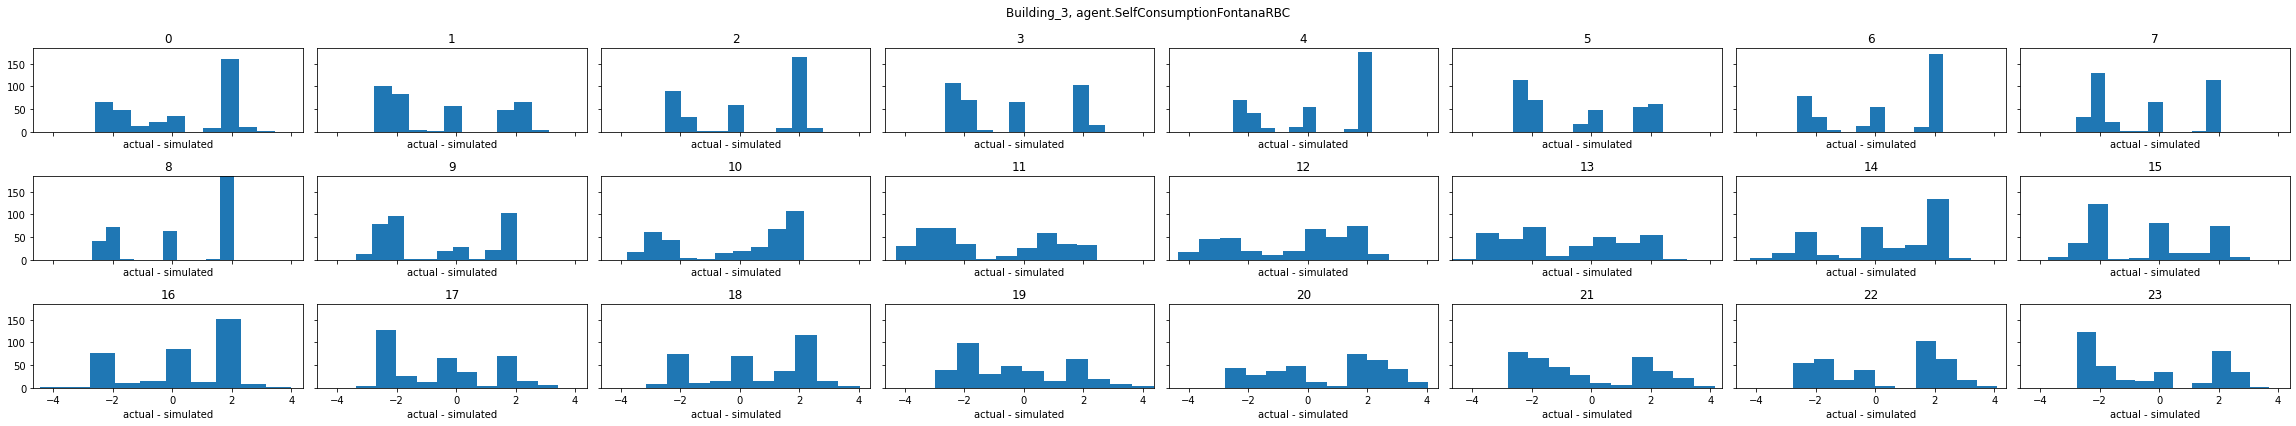

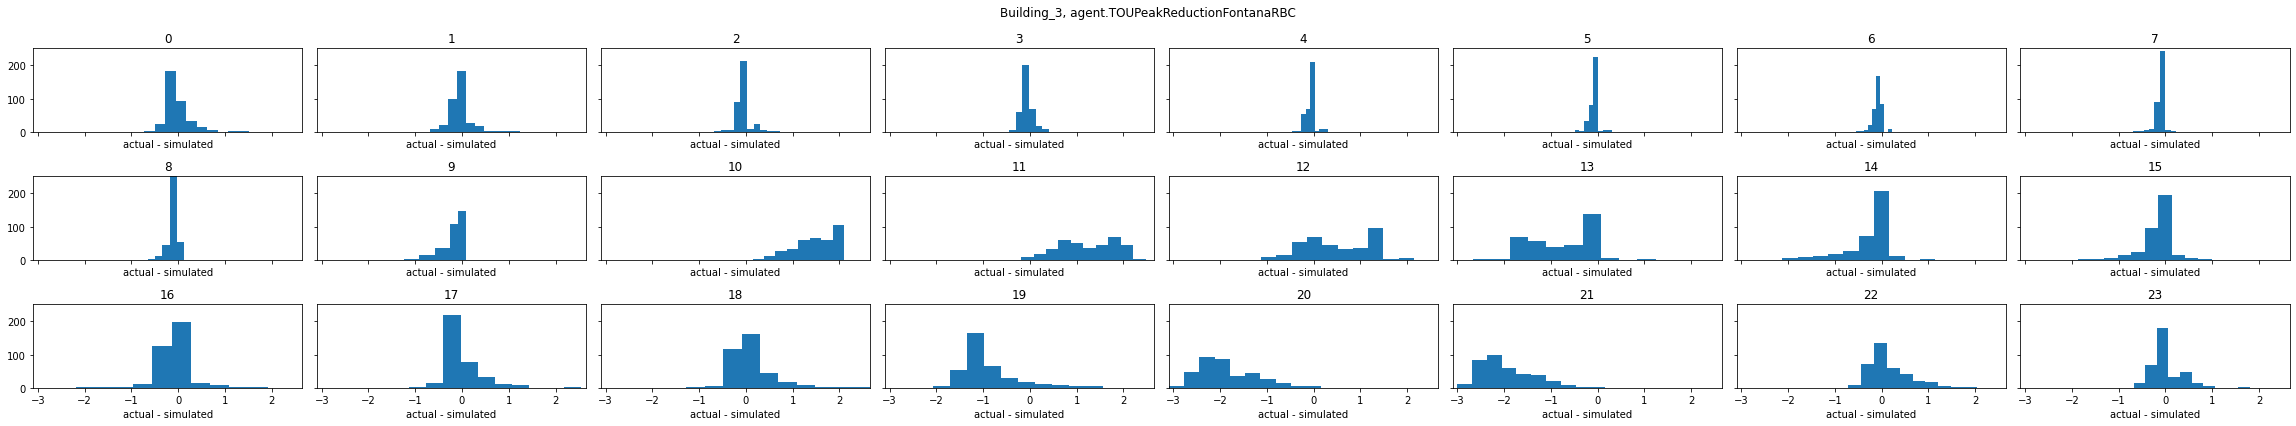

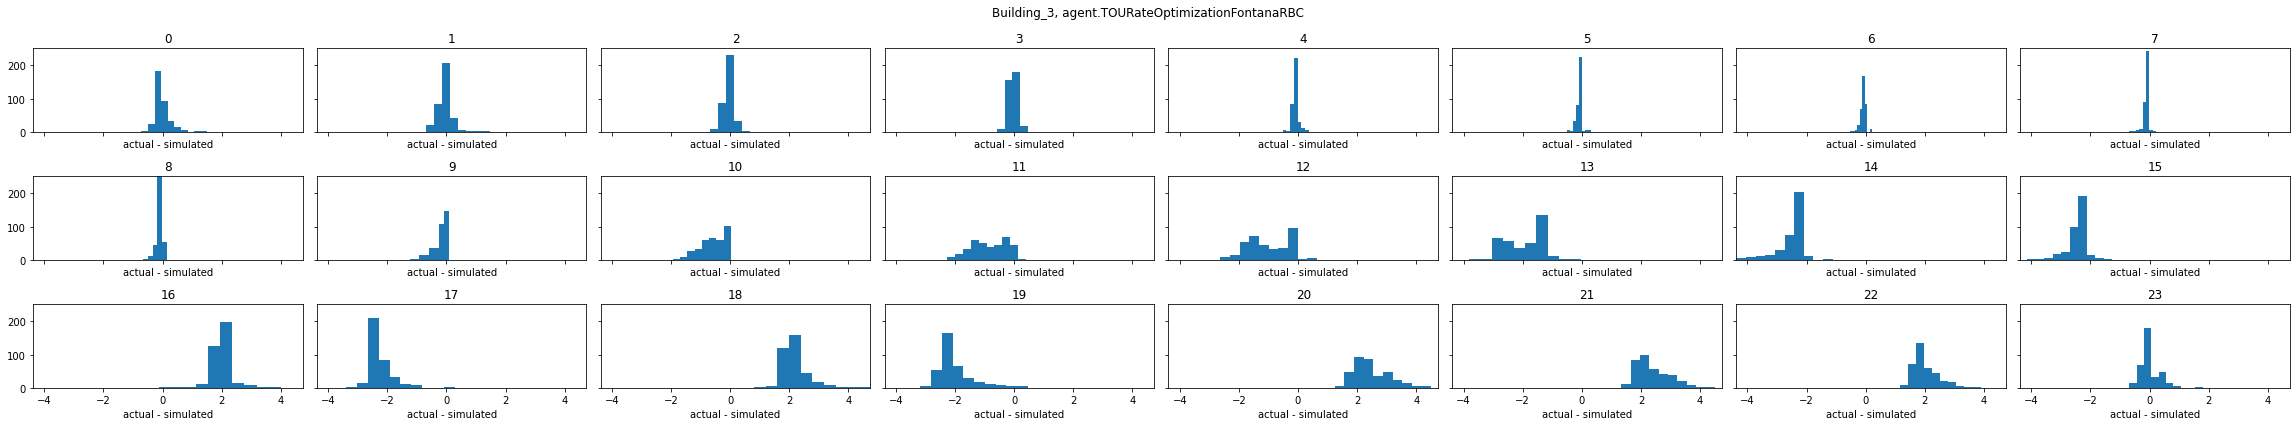

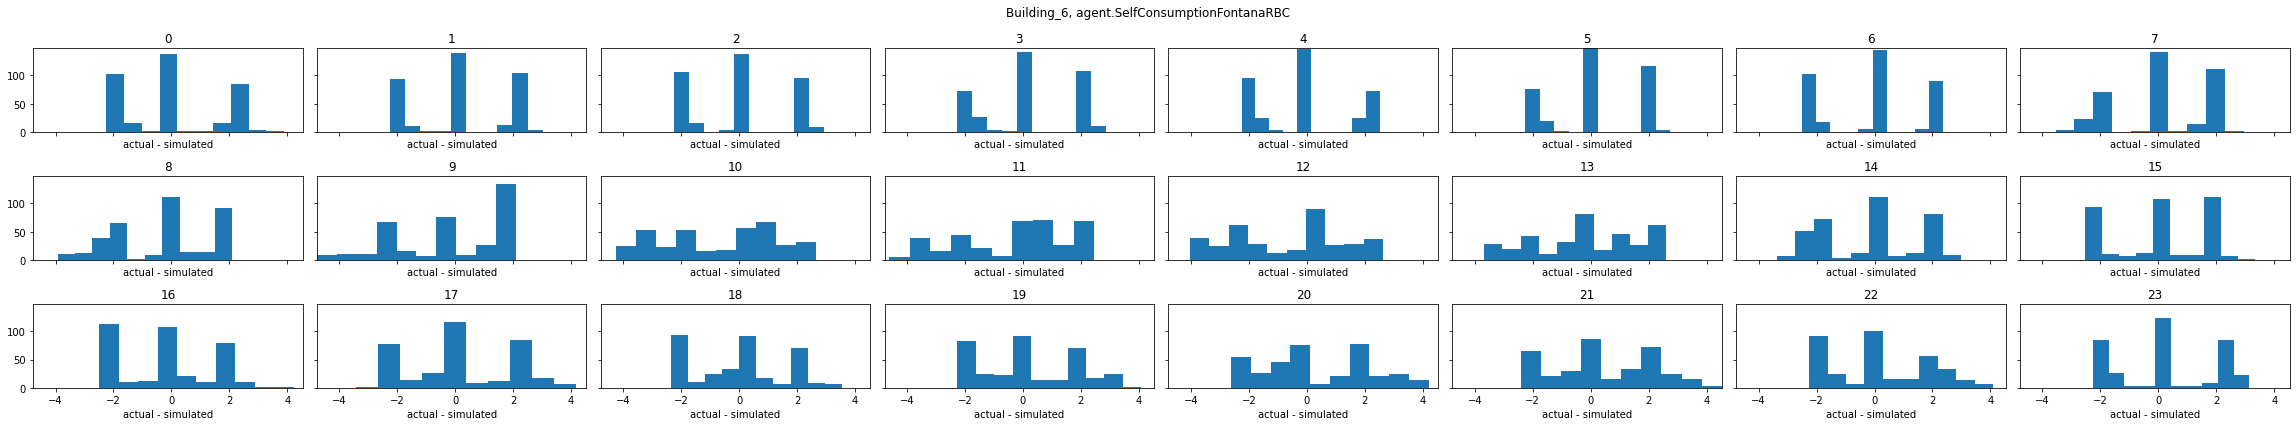

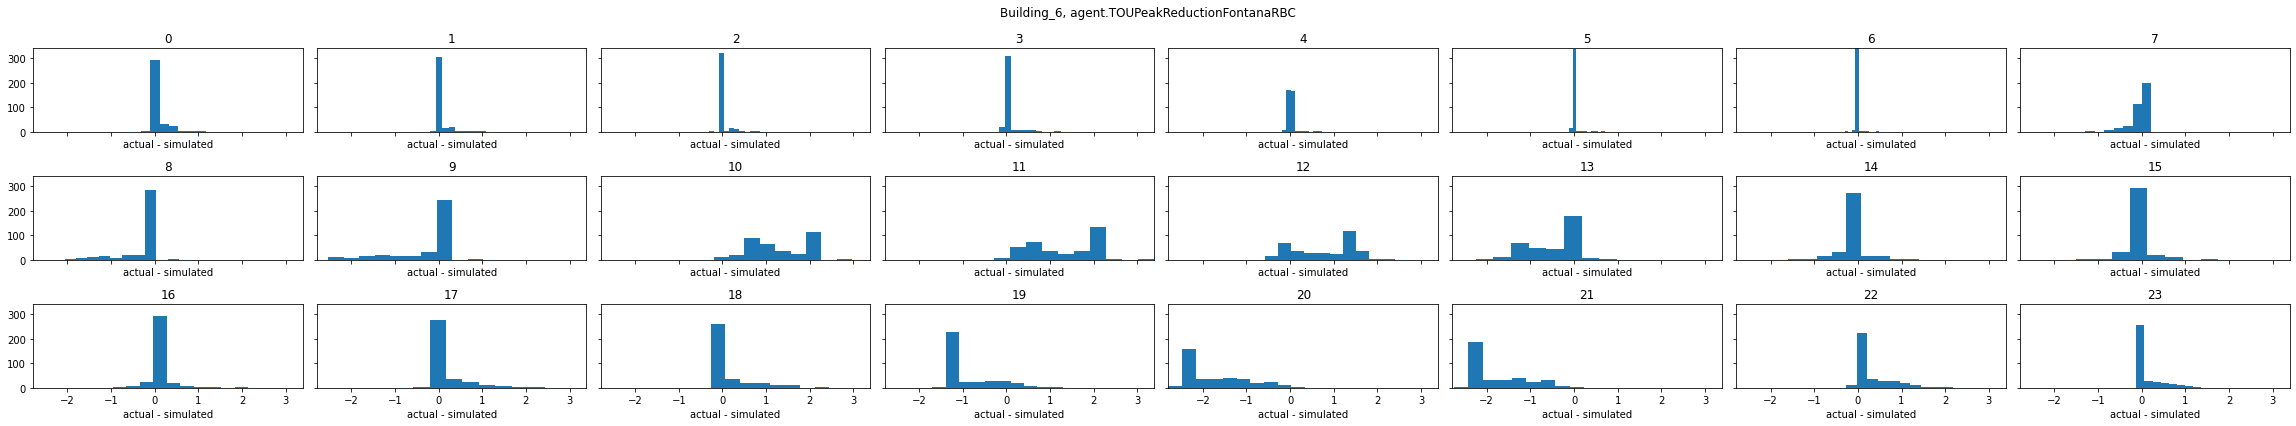

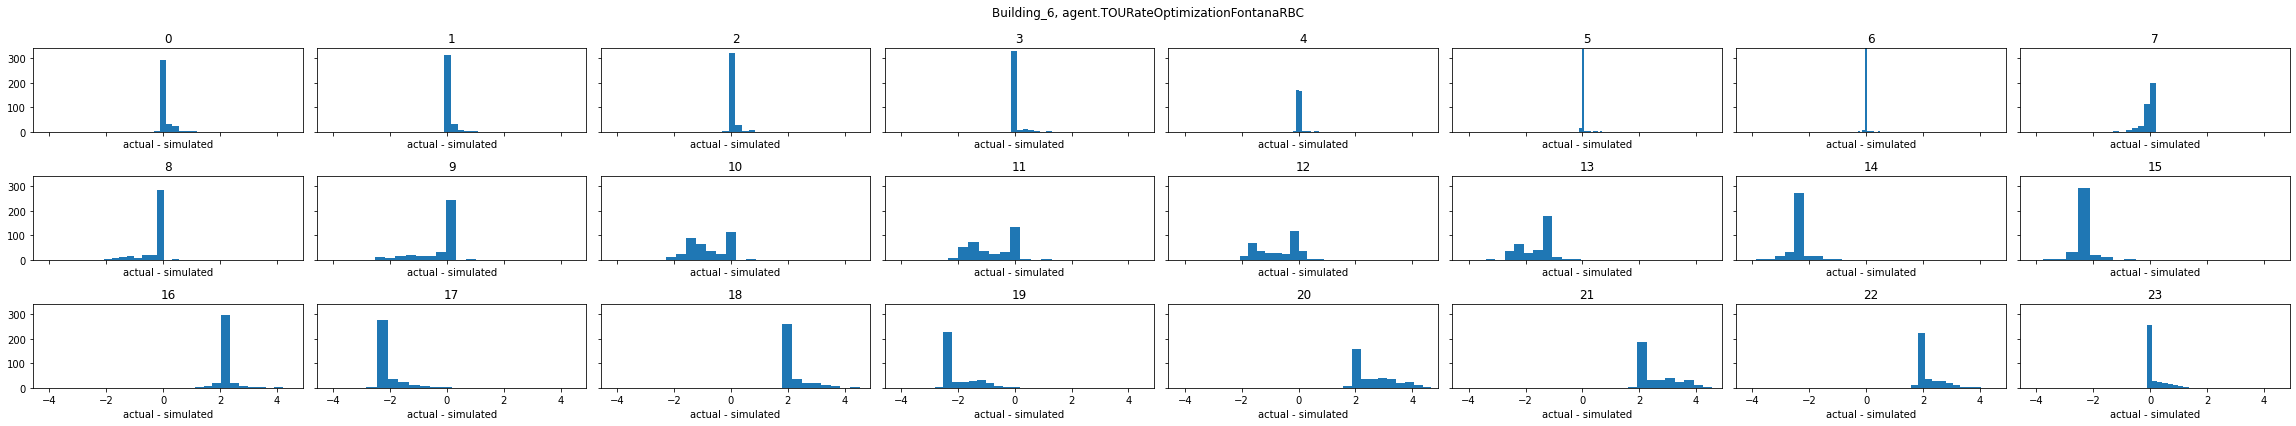

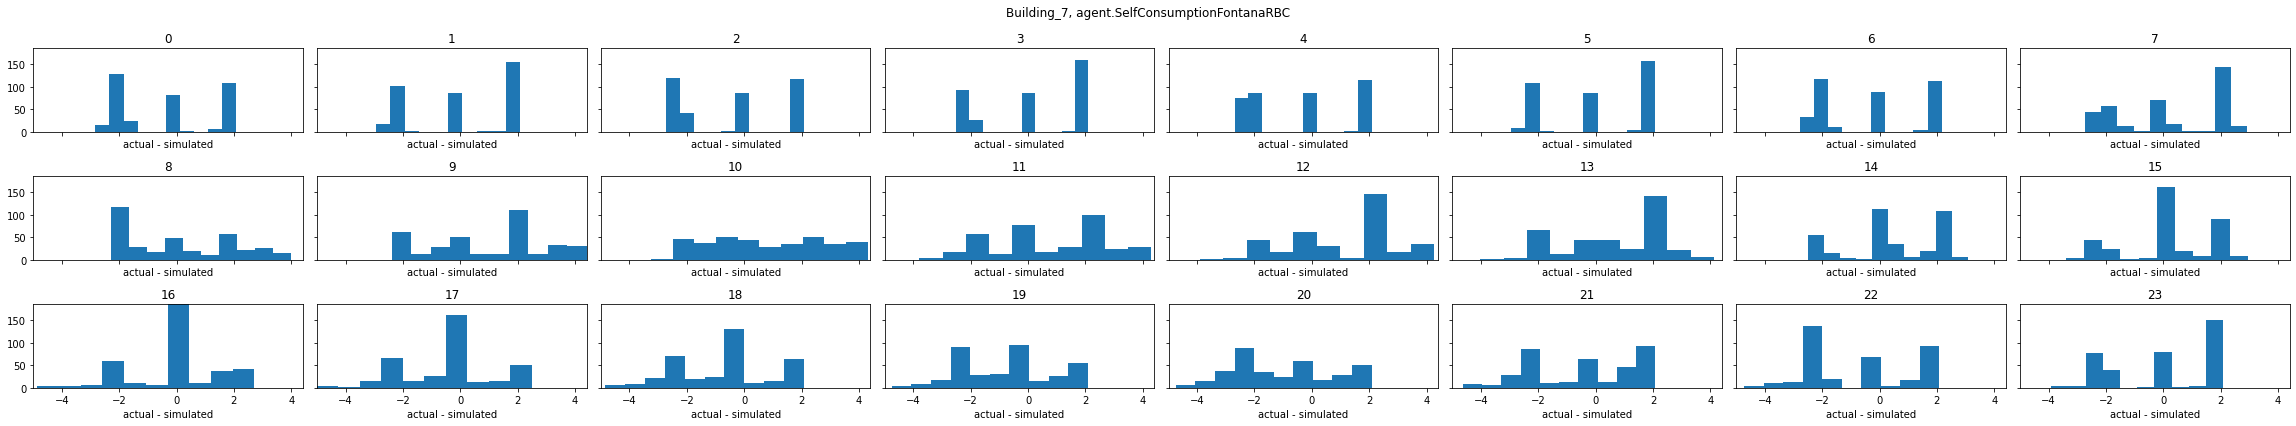

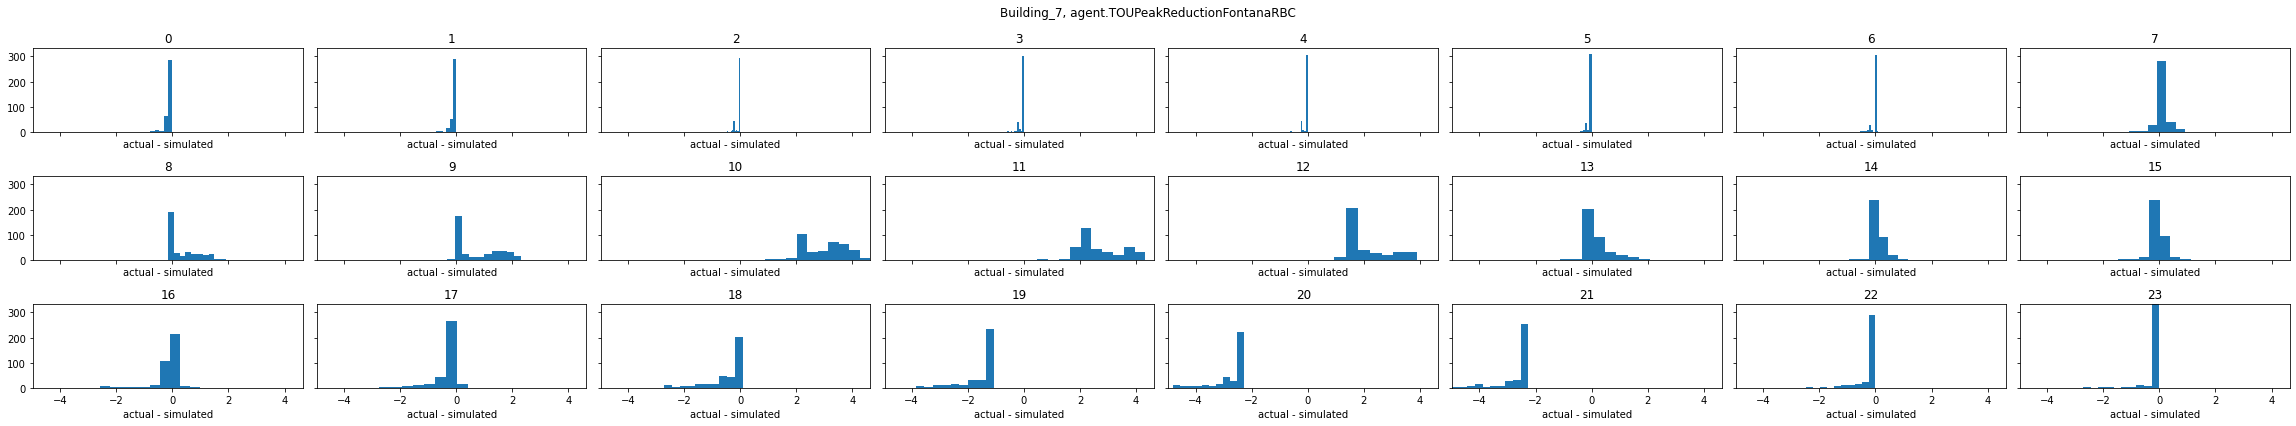

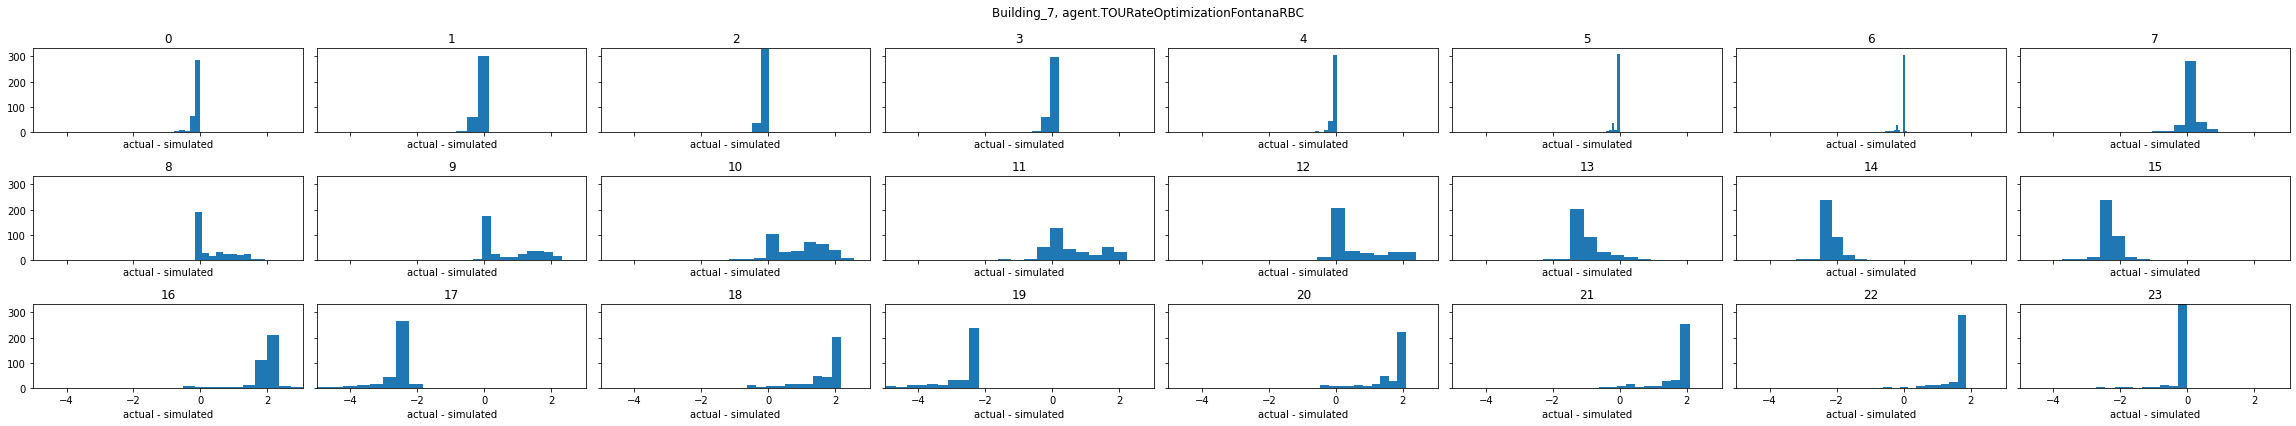

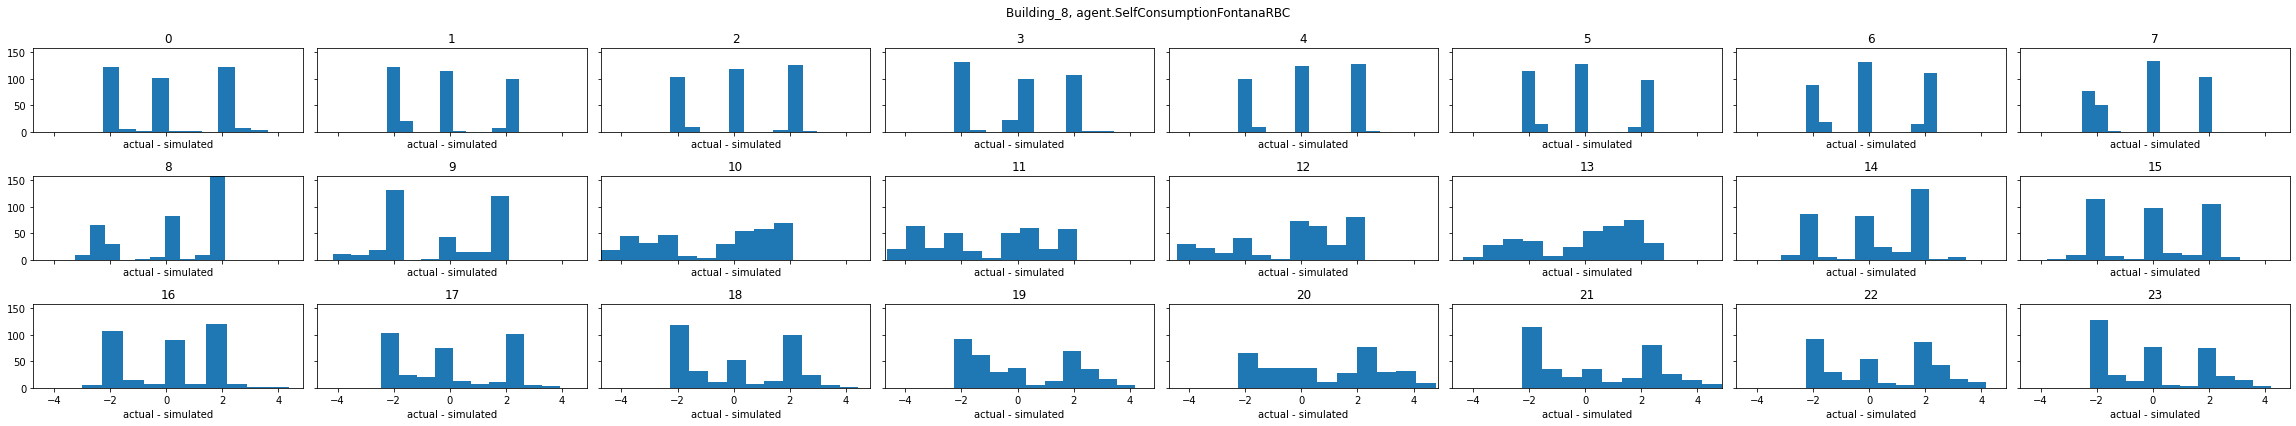

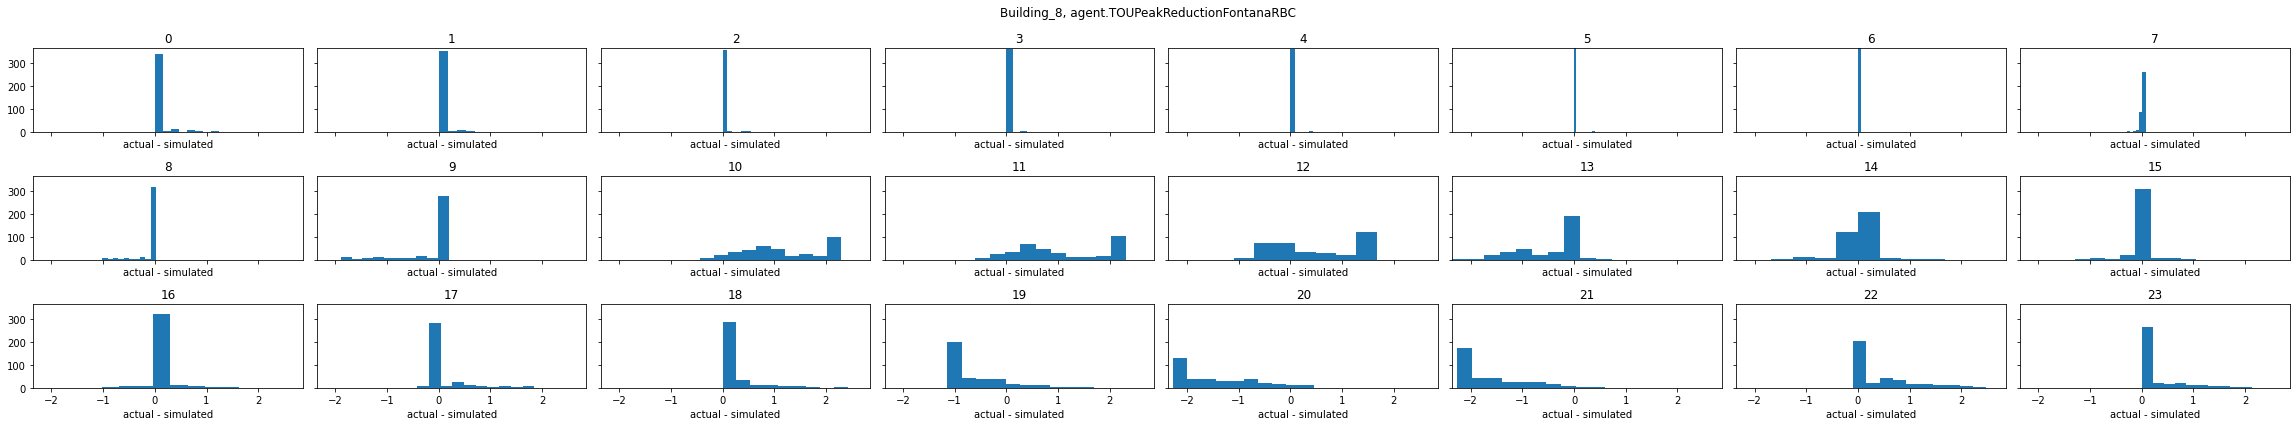

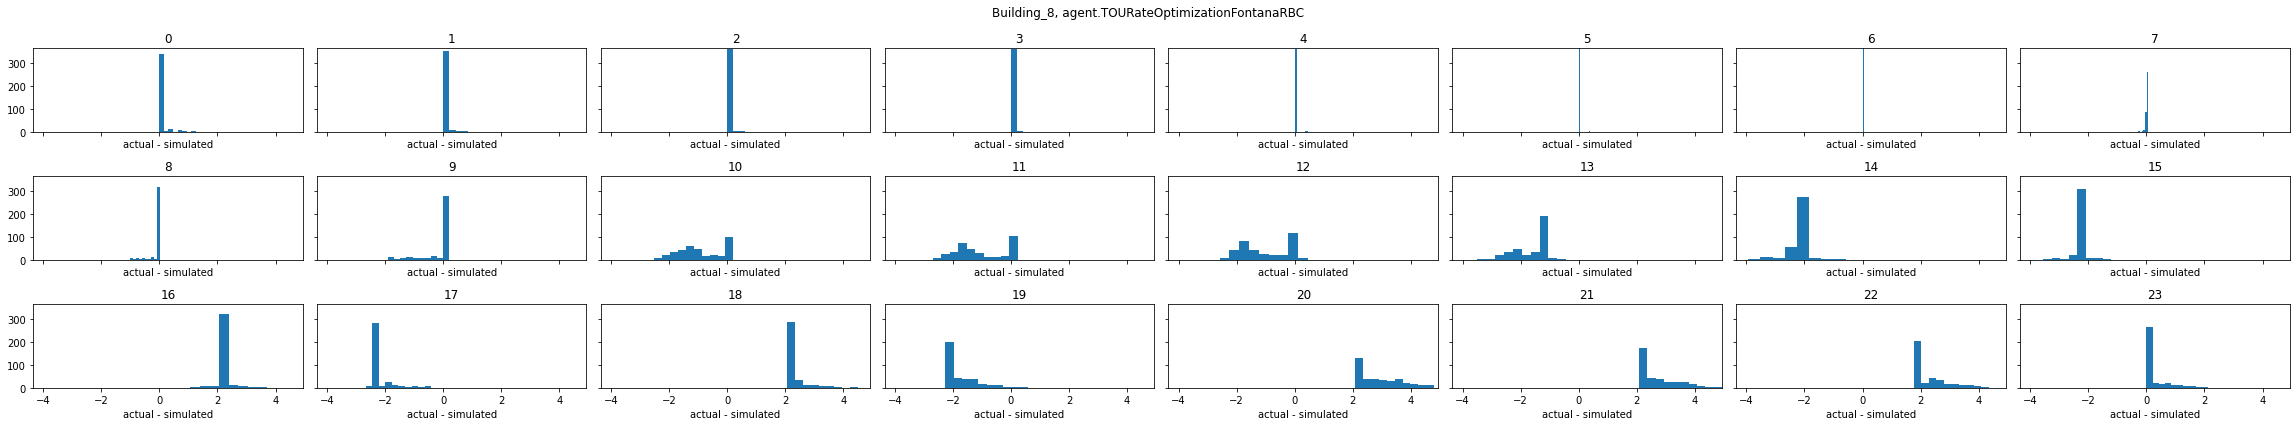

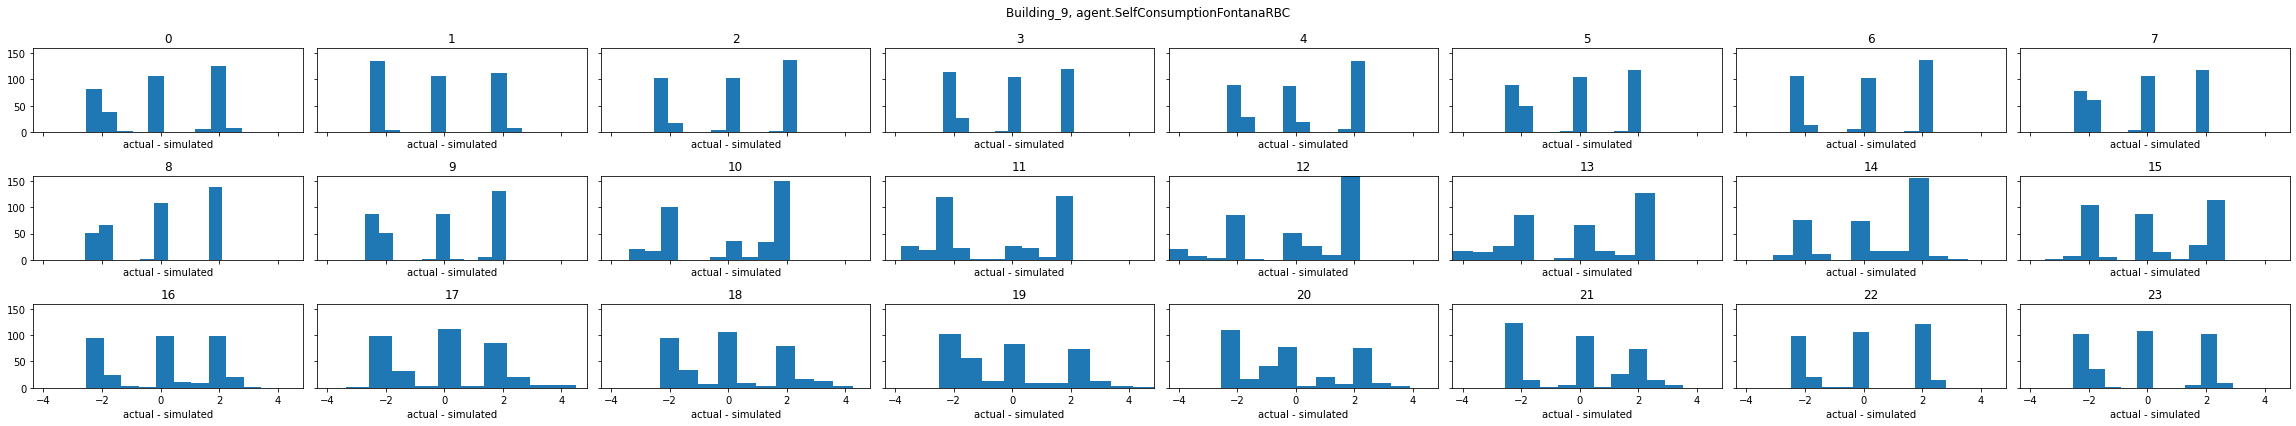

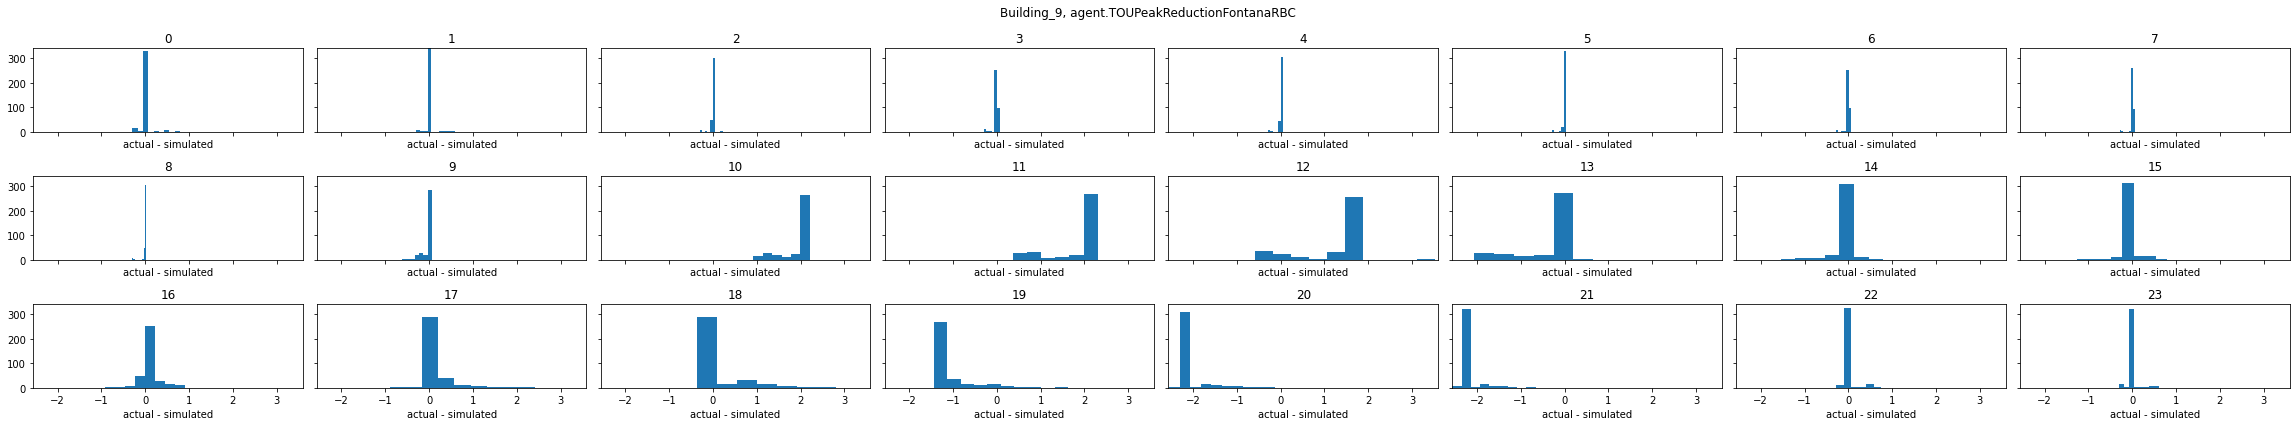

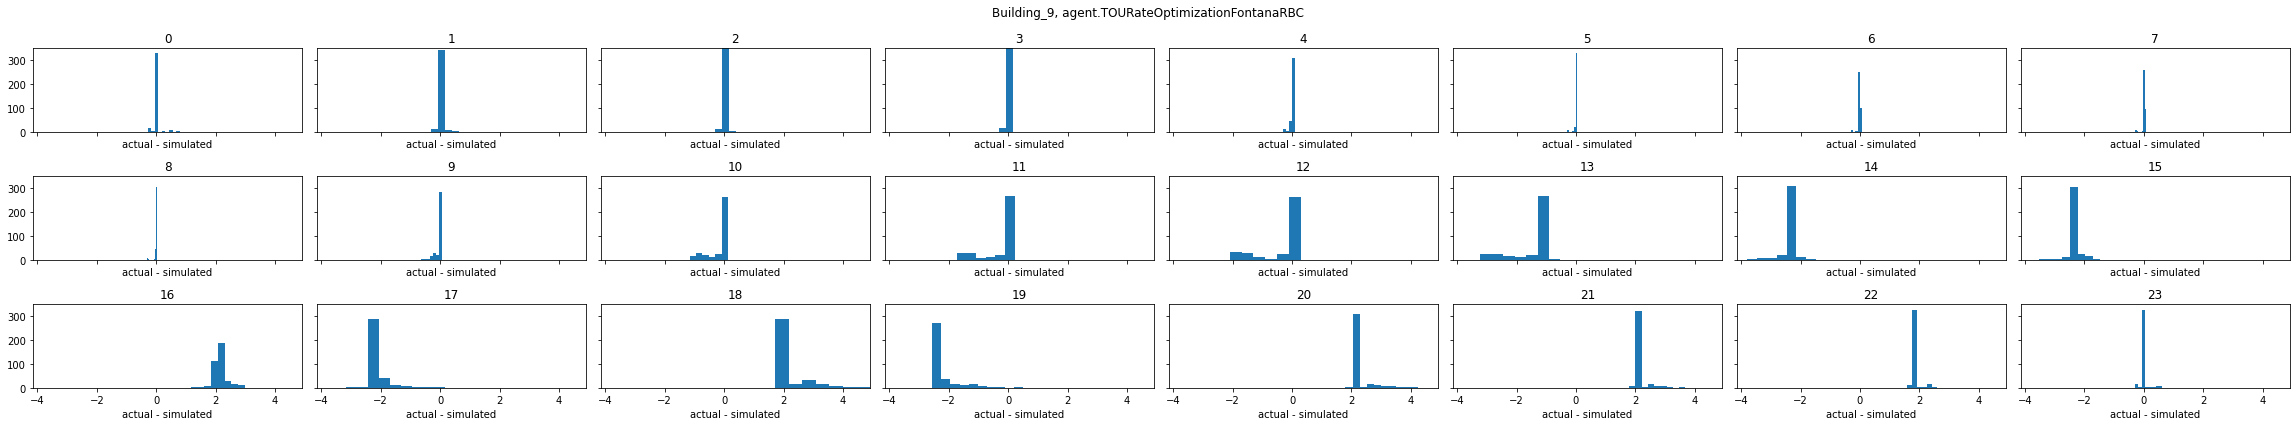

In [131]:
# how are the errors distributed hourly in a histogram?
column_count_limit = 8
hour_count = len(rbc_validation_simulations['hour'].unique())

for building, building_data in rbc_validation_simulations.groupby('building_id'):
    
    for rbc_type, rbc_data in building_data.groupby('type'):
        row_count = math.ceil(hour_count/column_count_limit)
        column_count = min(hour_count,column_count_limit)
        fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,2*row_count),sharey=True,sharex=True)

        for ax, (hour, hour_data) in zip(fig.axes,rbc_data.groupby('hour')):
            x = hour_data['error']
            ax.hist(x,bins=10)
            ax.set_xlabel('actual - simulated')
            ax.set_title(hour)
    
        fig.suptitle(f'{building}, {rbc_type}')
        plt.tight_layout()
        plt.show()
    
    # assert False

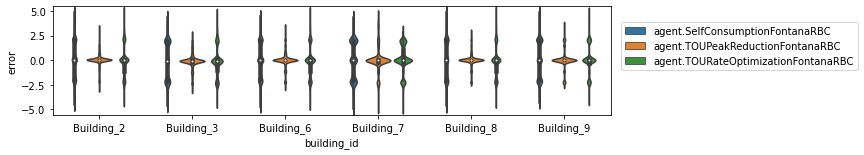

building_id                                 type     error            \
                                                          min       max   
0   Building_2      agent.SelfConsumptionFontanaRBC  0.001650  4.861753   
1   Building_2     agent.TOUPeakReductionFontanaRBC  0.000233  3.298010   
2   Building_2  agent.TOURateOptimizationFontanaRBC  0.000233  4.913941   
3   Building_3      agent.SelfConsumptionFontanaRBC  0.000167  4.672133   
4   Building_3     agent.TOUPeakReductionFontanaRBC  0.000017  3.101256   
5   Building_3  agent.TOURateOptimizationFontanaRBC  0.000017  4.739191   
6   Building_6      agent.SelfConsumptionFontanaRBC  0.000000  4.775136   
7   Building_6     agent.TOUPeakReductionFontanaRBC  0.000000  3.386477   
8   Building_6  agent.TOURateOptimizationFontanaRBC  0.000000  4.904248   
9   Building_7      agent.SelfConsumptionFontanaRBC  0.000000  4.994474   
10  Building_7     agent.TOUPeakReductionFontanaRBC  0.000000  4.964274   
11  Building_7  agent.TOURateOptimizationFontanaRBC  0.000000  4.998356   
12  Building_8      agent.SelfConsumptionFontanaRBC  0.000000  4.873047   
13  Building_8     agent.TOUPeakReductionFontanaRBC  0.000000  2.859277   
14  Building_8  agent.TOURateOptimizationFontanaRBC  0.000000  4.931451   
15  Building_9      agent.SelfConsumptionFontanaRBC  0.000000  4.856503   
16  Building_9     agent.TOUPeakReductionFontanaRBC  0.000000  3.592360   
17  Building_9  agent.TOURateOptimizationFontanaRBC  0.000000  4.902077   

                        
        mean       std  
0   1.438909  1.066928  
1   0.409936  0.631760  
2   1.061169  1.081623  
3   1.725916  0.868908  
4   0.506910  0.667566  
5   1.088785  1.060664  
6   1.389011  1.038571  
7   0.443248  0.685568  
8   1.061734  1.096048  
9   1.556937  1.018017  
10  0.754048  1.114251  
11  0.969708  1.002680  
12  1.591386  1.019862  
13  0.396447  0.647852  
14  1.090658  1.134444  
15  1.543338  0.951925  
16  0.484915  0.800188  
17  0.920427  1.054663

In [148]:
# error summary
rbc_validation_error_summary = rbc_validation_simulations.copy()
rbc_validation_error_summary['error'] = rbc_validation_error_summary['error'].abs()
rbc_validation_error_summary = rbc_validation_error_summary.groupby(['building_id','type'])[['error']].agg([min,max,'mean','std']).reset_index()
fig, ax = plt.subplots(1,1,figsize=(10,2))
sns.violinplot(x='building_id',y='error',data=rbc_validation_simulations,hue='type')
ax.legend(ncol=1,bbox_to_anchor= (1.01,0.9))
plt.show()

display(rbc_validation_error_summary)